[ML with Python] 4. 전문가 지식 활용
- 본 포스팅은 전문가 지식 활용에 관한 기본적인 내용에 관하여 다룹니다.


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1)-전문가-지식-활용" data-toc-modified-id="1)-전문가-지식-활용-1">1) 전문가 지식 활용</a></span></li><li><span><a href="#2)-References" data-toc-modified-id="2)-References-2">2) References</a></span></li></ul></div>

---

필요라이브러리 import

In [47]:
import mglearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['axes.unicode_minus'] = False 
plt.rc('font', family='Malgun Gothic') 

<br>

---

### 1) 전문가 지식 활용

- `특성 공학` : 특정한 애플리케이션을 위해 `전문가의 지식(Expert Knowledge)`를 사용할 수 있는 중요한 영역
    - 대부분의 경우 머신러닝의 목적은 전문가가 설계하는 규칙을 만들지 않기 위해서지만,<br> <u>종종 분야 전문가는 초기 데이터에서 유용한 특성을 선택할 수 있도록 도움을 준다</u>.
    - ex) 항공료를 예측할 경우의 변수 : 공휴일, 방학 전후의 여행 스케줄에 관한 특성 데이터
    - but, 이러한 사전 지식 특성이 머신러닝 알고리즘에 도움이 될 수 있지만 반드시 그 특성을 사용하는 것은 아니다! 

<br>

`전문가 지식`을 사용하는 전형적인 사례(앤디 집 앞의 자전거가 대여 가능한지 예측하는 작업)를 살펴보자. 여기서 보고자하는 문제는 특정 날짜와 시간에 앤디 집 앞에 있는 자전거를 사람들이 얼마나 대여할 것인지 예측하는 것이다.

<br>

먼저 데이터 프레임을 읽어오고, 8월 한달 동안의 대여 횟수를 그래프로 나타내보자.

In [3]:
citibike = mglearn.datasets.load_citibike()

df_citibike = citibike.to_frame().reset_index()
df_citibike.columns = ['대여 날짜', '대여 횟수']
df_citibike.head()

,대여 날짜,대여 횟수
0,2015-08-01 00:00:00,3
1,2015-08-01 03:00:00,0
2,2015-08-01 06:00:00,9
3,2015-08-01 09:00:00,41
4,2015-08-01 12:00:00,39


Text(0, 0.5, '대여횟수')

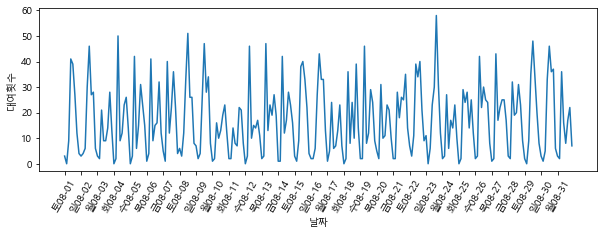

In [4]:
plt.figure(figsize = (10, 3))
xticks = pd.date_range(start = citibike.index.min(), end = citibike.index.max(), freq = 'D')
week = ['월', '화', '수', '목', '금', '토', '일']
xticks_name = [week[w] + d for w, d in zip(xticks.weekday, xticks.strftime('%m-%d'))]

plt.plot(df_citibike.iloc[:, 0], df_citibike.iloc[:, 1])
plt.xticks(xticks, xticks_name,rotation = 60)
plt.xlabel('날짜')
plt.ylabel('대여횟수')

데이터를 보면 24시간 간격으로 낮과 밤을 구분할 수 있다. 또한 주중과 주말의 패턴에서도 차이를 보이는 것 같다. 이와 같은 `시계열 데이터`를 이용한 예측 작업은 <u>과거 데이터에서 학습하여 미래를 예측하는 방식</u>을 사용한다. 시계열 데이터에서의 훈련 세트와 테스트 세트는 다음과 같다.

- `훈련 세트` : 특정 날짜까지의 모든 데이터
- `테스트 세트` : 특정 날짜이후의 모든 데이터 

<br>

해당 예제에서는 23일 치 184개 데이터 포인트를 `훈련 세트`, 남은 8일 치 64개 데이터 포인트를 `테스트 세트`로 사용하겠다. 또한 데이터 전처리가 거의 필요하지 않아 처음 시도하기 좋은 `랜덤포레스트`를 예측 모델로 사용하겠다.

테스트 세트 R^2 : -0.04
range(184, 248)


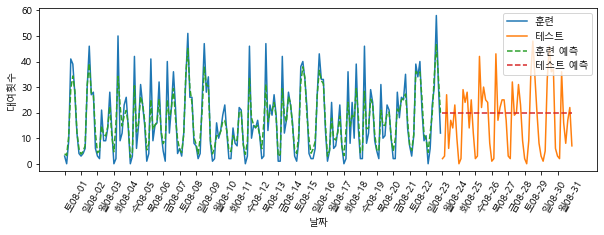

In [23]:
# 타깃값(대여 횟수)
y = citibike.values

# POSIX 시간 : 1970년 1월 1일 00시 00분 00초 부터 경과한 시간을 초로 나타냄
# POSIX 시간을 10**9로 나누어 변환
X = citibike.index.astype('int64').values.reshape(-1, 1)

# 처음 184개 데이터 포인트를 훈련세트로 사용 나머지는 테스트 세트
n_train = 184

def eval_on_features(features, target, regressor):
    #훈련 세트와 테스트 세트로 나눈다.
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    
    regressor.fit(X_train, y_train)
    
    print("테스트 세트 R^2 : {:.2f}".format(regressor.score(X_test, y_test)))
    
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    plt.figure(figsize=(10,3))
    plt.xticks(range(0, len(X), 8), xticks_name, rotation = 60, ha = 'left')
    
    plt.plot(range(n_train), y_train, label = '훈련')
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label = '테스트')

    plt.plot(range(n_train), y_pred_train, '--', label = '훈련 예측')
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label = '테스트 예측')
    
    plt.legend(loc = 'best')
    plt.xlabel('날짜')
    plt.ylabel('대여횟수')
    
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state = 0)
eval_on_features(X, y, regressor)

`랜덤 포레스트 모델`이 그렇듯이 `훈련 세트`의 예측은 매우 정확하다. 그런데 테스트 세트에 대해서는 한가지 값으로만 예측하였다. 더불어 R^2값은 -0.04로, 아무것도 학습되지 않았다는 것을 나타낸다.

<br>

이러한 문제가 발생한 이유는 <u>테스트 세트에 있는 POSIX시간 특성의 값은 훈련 세트에 있는 특성 값의 범위 밖에 있기 때문이다</u>. 즉 테스트 세트에 있는 데이터 포인터는 훈련 세트에 있는 모든 데이터보다 뒤에 있기에 발생한 문제이다. <u>트리 모델인 랜덤 포레스트는 훈련 세트에 있는 특성의 범위 밖으로는 외삽(extrapolation)할 수 있는 능력이 없다</u>.

<br>

결국 이 모델은 `테스트 세트`와 가장 가까이 있는 `마지막 훈련 세트` 데이터의 타깃값을 예측으로 사용하게 된다.

<br>

하지만, 여기에 `전문가 지식`<u>을 첨가하게 되면 더 나은 결과를 도출 할 수 있게 된다</u>. 훈련 데이터의 대여 데이터 그래프를 보면 (POSIX시간 데이터에는 표현되지 않은)시간과 요일이라는 두 요소가 패턴을 형성하는데 있어 중요한 것으로 보인다. 먼저 시간을 첨부해보자.

테스트 세트 R^2 : 0.60
range(184, 248)


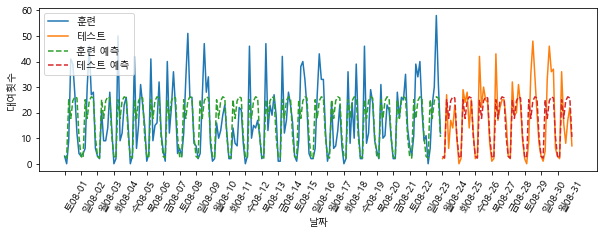

In [28]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
eval_on_features(X_hour, y, regressor)

R^2는 이전보다 나아졌지만, 패턴까지는 예측하지 못 하고 있다. 그렇다면 요일 정보까지 추가해보자.

테스트 세트 R^2 : 0.84
range(184, 248)


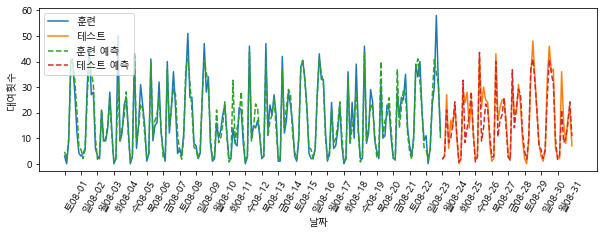

In [36]:
# 특성 1에 요일, 특성 2에 시간 [요일, 시간]
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1), citibike.index.hour.values.reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)

이제 모델은 하루의 시간과 요일에 따른 주기적인 패턴을 따르고 있는 것을 확인할 수 있다. 더불어 R^2도 0.84로 좋은 예측 성능을 보여준다.
또한, 8월 24일 일요일의 결과와 8월 31일의 결과가 동일한 것으 확인할 수 있는데, 이것은 랜덤 포레스트 회귀로 만든 예측은 여러 트리가 예측한 값들의 평균이기 때문이다.

<br>

`랜덤 포레스트`보다 더 간단한 모델인 `LinearRegression`을 적용해보자.

테스트 세트 R^2 : 0.13
range(184, 248)


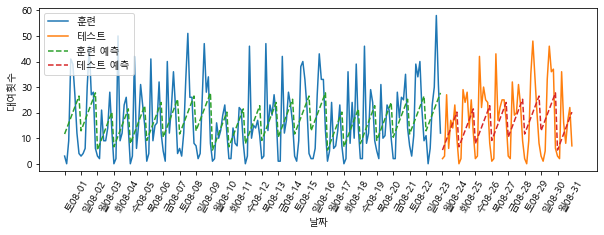

In [40]:
from sklearn.linear_model import LinearRegression
eval_on_features(X_hour_week, y, LinearRegression())

`LinearRegression`은 `랜덤 포레스트`와 똑같은 입력값을 넣었음에도 불구하고 성능도 나쁘며 주기적인 패턴도 이상하게 출력되는 것을 확인할 수 있다. 왜냐하면, <u>요일과 시간이 정수로 인코딩되어 있어서 연속형 변수로 해석되기 때문이다</u>.

<br>

따라서, 패턴을 잡기 위해서는 `OneHotEncoder`를 사용하여 정수형을 범주형으로 해석할 필요가 있다.

테스트 세트 R^2 : 0.62
range(184, 248)


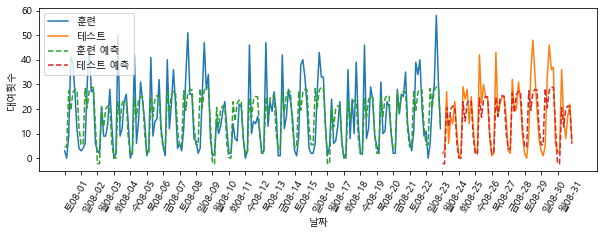

In [46]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

eval_on_features(X_hour_week_onehot, y, LinearRegression())

`원 핫 인코더`로 인코딩 후 기존 연속형 특성을 가졌을 때 보다 훨씬 좋아졌다.

<br>

여기서 더 욕심을 내서 `상호작용 특성`을 사용하면 시간과 요일의 조합별 계수를 학습시켜 랜덤 포레스트와 비슷한 더 나은 결과를 얻을 수 있다.

테스트 세트 R^2 : 0.84
range(184, 248)


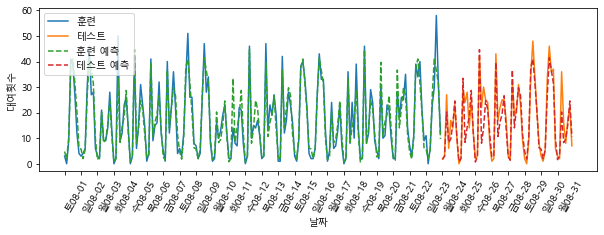

In [49]:
from sklearn.preprocessing import PolynomialFeatures
poly_transform = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

X_hour_week_onehot_poly = poly_transform.fit_transform(X_hour_week_onehot)

eval_on_features(X_hour_week_onehot_poly, y, LinearRegression())

<br>

---

### 2) References

- 안드레아스 뮐러, 세라 가이도, 『파이썬 라이브러리를 활용한 머신러닝』, 박해선, 한빛미디어(2017)